In [1]:
# Standard library imports
import time
import concurrent.futures
from math import tanh, sqrt, fabs, erf as math_erf

# Third-party imports

# Numerical computations
import numpy as np
from numpy.polynomial import Chebyshev

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Output, RadioButtons

# Scientific computing
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.interpolate import UnivariateSpline, interp1d

# Performance enhancement
from numba import njit

# Workflow for Color Fringe Computation and Chromatic Correction
This document outlines the steps needed to simulate chromatic aberration effects, including data import, interpolation, interactive curve fitting, and analysis of color fringe width. The simulation takes into account the physics of chromatic aberration, sensor response, and overexposure effects.

## 1. Data Import

In [2]:
# Wavelength ranges
wvl_chl = np.arange(400, 701, 10)
wvl_day = np.arange(380, 691, 10)
wvl_sensor = np.arange(400, 701, 10)

# Corresponding values
def stack_data(wavelengths, values):
    return np.column_stack((wavelengths, values))

CHLzf85 = stack_data(wvl_chl, [
    285, 190, 118,  63,  22,  -9, -31, -46, -56, -62,
     -64, -63, -60, -54, -48, -39, -30, -20,  -9,   3,
      15,  28,  41,  54,  68,  82,  96, 111, 125, 139,
     156
])

Daylight_in = stack_data(wvl_day, [
     11,  16,  22,  33,  48,  62,  71,  78,  84,  92,
     97, 100,  96,  95,  95,  94,  90,  78,  70,  78,
     88,  94,  91,  85,  82,  85,  92, 100,  89,  76,
     83, 100
])

# Sensor responses per channel
sensor_vals = {
    "Blue": [
        0.42, 9.08, 24.34, 28.37, 40.12, 39.01, 47.12, 46.65, 41.14, 26.73,
        14.75, 7.55, 2.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 0.84, 0.32, 0.04, 0.0
    ],
    "Green": [
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.63, 6.48, 9.09,
        17.75, 28.39, 37.8, 38.39, 35.02, 28.83, 28.1, 19.02, 13.1, 6.96,
        4.33, 3.34, 3.02, 0.0, 0.0, 0.0, 0.69, 0.7, 0.34, 0.05, 0.0
    ],
    "Red": [
        0.0, 1.3, 1.86, 2.17, 1.73, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.38, 60.18, 100.0,
        92.73, 72.75, 50.6, 35.81, 35.08, 22.4, 16.96, 7.75, 3.3, 0.78, 0.18
    ]
}

sensors = {name: stack_data(wvl_sensor, vals) for name, vals in sensor_vals.items()}
SensorBlue, SensorGreen, SensorRed = sensors['Blue'], sensors['Green'], sensors['Red']

# Verify shapes
for name, arr in [('CHLzf85', CHLzf85), ('Daylight', Daylight_in), *sensors.items()]:
    print(f"{name} shape: {arr.shape}")

CHLzf85 shape: (31, 2)
Daylight shape: (32, 2)
Blue shape: (31, 2)
Green shape: (31, 2)
Red shape: (31, 2)


In [3]:
def CHLfit_poly(lam_nm):
    return np.polyval(CHL_coeffs, lam_nm)

def CHLfit_conrady(lam_nm, A, B, C):
    return A + B/lam_nm + C/lam_nm**3.5       # µm

lam_CHL, defocus_CHL = CHLzf85[:, 0], CHLzf85[:, 1]
lam_fit = np.linspace(400, 700, 301)
nu_CHL = 1.0 / lam_CHL    # nm⁻¹
nu_fit  = 1.0 / lam_fit    # nm⁻¹

CHL_coeffs = np.polyfit(lam_CHL, defocus_CHL, 6)
print("CHL fit coefficients:", CHL_coeffs)
defocus_fit_poly = CHLfit_poly(lam_fit)

p0 = (0.0, 1e5, -1e11)                        # initial guesses
popt, pcov = curve_fit(CHLfit_conrady, lam_CHL, defocus_CHL, p0=p0)
A, B, C = popt
print(f"Conrady coefficients:\n"
      f"   A = {A:.4f} µm   B = {B:.4e} µm·nm   C = {C:.4e} µm·nm³·⁵")
defocus_fit_conr = CHLfit_conrady(lam_fit, *popt)         # µm

CHL fit coefficients: [ 6.17055255e-12 -2.17284405e-08  3.18690992e-05 -2.49424071e-02
  1.09994225e+01 -2.59404221e+03  2.55683162e+05]
Conrady coefficients:
   A = 2018.5575 µm   B = -1.4912e+06 µm·nm   C = 2.5152e+12 µm·nm³·⁵


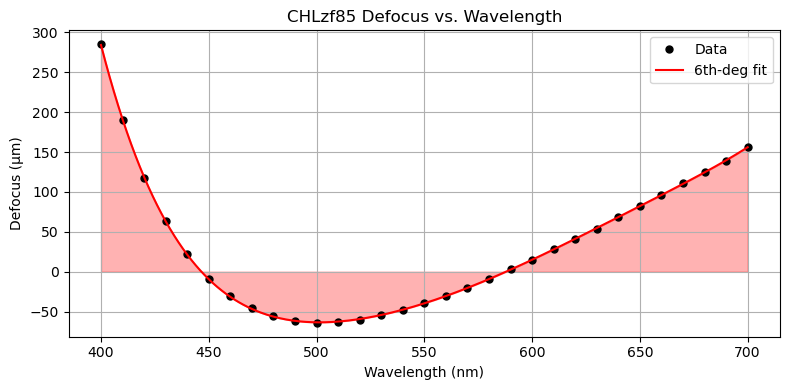

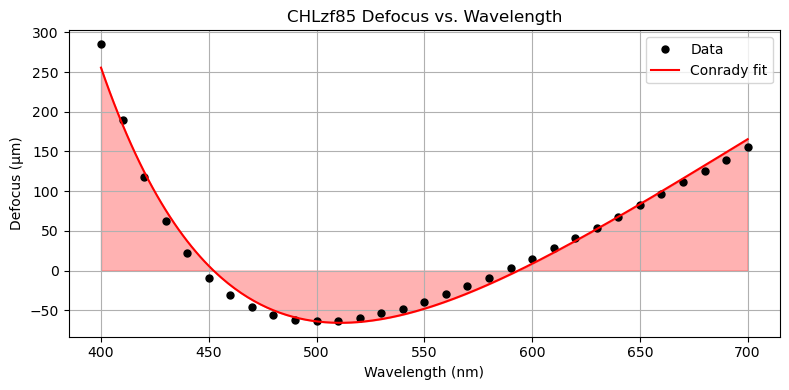

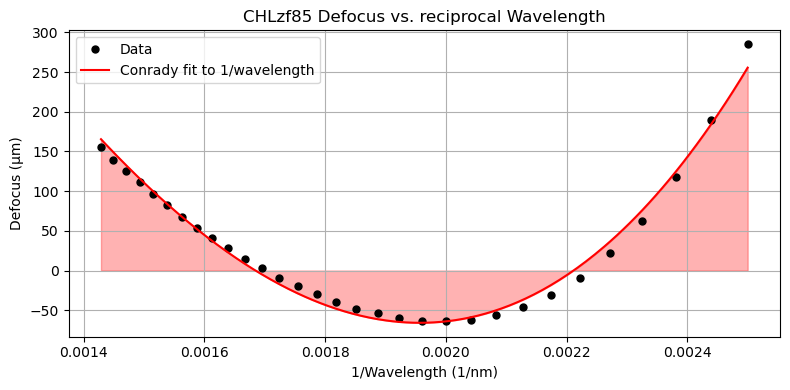

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(lam_CHL, defocus_CHL, 'o', color='black', markersize=5, label='Data')
plt.plot(lam_fit, defocus_fit_poly, '-', color='red', label='6th-deg fit')
plt.fill_between(lam_fit, defocus_fit_poly, color='red', alpha=0.3)
plt.title('CHLzf85 Defocus vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(lam_CHL, defocus_CHL, 'o', color='black', markersize=5, label='Data')
plt.plot(lam_fit, defocus_fit_conr, '-', color='red', label='Conrady fit')
plt.fill_between(lam_fit, defocus_fit_conr, color='red', alpha=0.3)
plt.title('CHLzf85 Defocus vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(nu_CHL, defocus_CHL, 'o', color='black', markersize=5, label='Data')
plt.plot(nu_fit, defocus_fit_conr, '-', color='red', label='Conrady fit to 1/wavelength')
plt.fill_between(nu_fit, defocus_fit_conr, color='red', alpha=0.3)
plt.title('CHLzf85 Defocus vs. reciprocal Wavelength')
plt.xlabel('1/Wavelength (1/nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
def resample_poly(spectrum, new_waves, degree=6):
    w, inten = spectrum[:,0], spectrum[:,1]
    coeffs = np.polyfit(w, inten, degree)
    y = np.poly1d(coeffs)(new_waves)
    return np.column_stack((new_waves, y / y.max() * 100))

# Compute normalization factor so ∫(sensor·illuminant) dλ = 1
def norm_factor(sensor, illuminant):
    lam = sensor[:,0]
    raw = np.trapezoid(sensor[:,1] * illuminant[:,1], x=lam)
    return (1/raw if raw else 0), raw

# Plot helper: line + fill
def plot_curve(data, color, label):
    lam, inten = data[:,0], data[:,1]
    plt.plot(lam, inten, color=color, label=label)
    plt.fill_between(lam, inten, alpha=0.3)

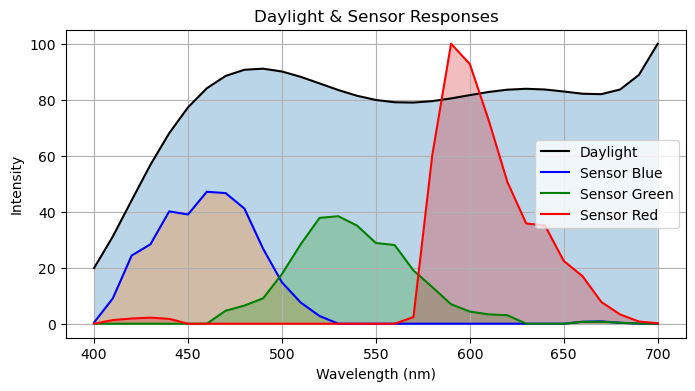

Sensor Blue: raw ∫=253598.07, factor=3.9432e-06
Sensor Green: raw ∫=238856.89, factor=4.1866e-06
Sensor Red: raw ∫=413821.66, factor=2.4165e-06


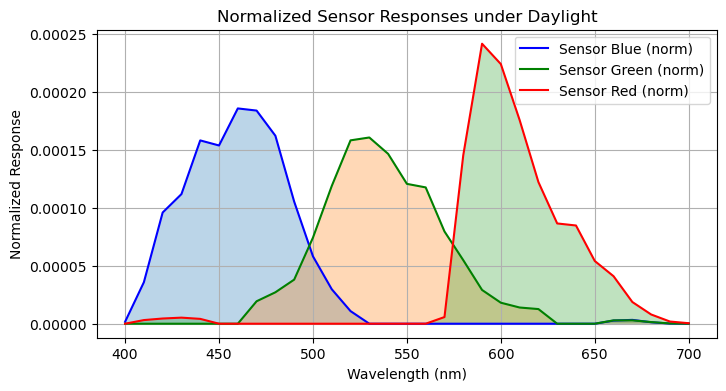

Shapes: (31, 2) (31, 2) (31, 2)


In [6]:
# === Part 1: Resample & Plot ===
Daylight = resample_poly(Daylight_in, lam_CHL)
plt.figure(figsize=(8,4))
plot_curve(Daylight, 'k', 'Daylight')

# Raw sensor curves
default_colors = {'Sensor Blue':'blue', 'Sensor Green':'green', 'Sensor Red':'red'}
sensors = {'Sensor Blue':SensorBlue, 'Sensor Green':SensorGreen, 'Sensor Red':SensorRed}
for name, data in sensors.items():
    plot_curve(data, default_colors[name], name)

plt.title('Daylight & Sensor Responses')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend(); plt.grid(True)
plt.show()

# === Part 2: Normalize & Plot ===
plt.figure(figsize=(8,4))
normed = {}
for name, data in sensors.items():
    factor, raw_int = norm_factor(data, Daylight)
    norm_data = data.copy()
    norm_data[:,1] *= factor
    normed[name] = norm_data
    print(f"{name}: raw ∫={raw_int:.2f}, factor={factor:.4e}")
    plot_curve(norm_data, default_colors[name], f"{name} (norm)")

plt.title('Normalized Sensor Responses under Daylight')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend(); plt.grid(True)
plt.show()

# Expose normalized arrays for further use
SensorBlue_norm = normed['Sensor Blue']
SensorGreen_norm = normed['Sensor Green']
SensorRed_norm = normed['Sensor Red']

print("Shapes:", SensorBlue_norm.shape, SensorGreen_norm.shape, SensorRed_norm.shape)


## 2. CHL Curve Modification and Visualization

In [7]:
# Pre-calculations and Setup
dlam = lam_fit[1] - lam_fit[0]
min_idx = np.argmin(defocus_fit_poly)
lam_min, defocus_min = lam_fit[min_idx], defocus_fit_poly[min_idx]
print("Original lowest point at λ = {:.2f} nm, defocus = {:.2f} µm".format(lam_min, defocus_min))

# rebuild your interpolators/splines on the correct arrays
linear_fit = interp1d(lam_fit, defocus_fit_poly, kind='linear', fill_value="extrapolate")
spline_fit = UnivariateSpline(lam_fit, defocus_fit_poly, s=0)

Original lowest point at λ = 501.00 nm, defocus = -63.42 µm


In [8]:
def CHLfit_mod_overall(lam_vals: np.ndarray, lam_shift: float = 0.0, tilt: float = 0.0):
    """
    Apply a horizontal shift and tilt to modify the CHL curve.
    For lam < pivot: derivative scaled by (1 - tilt)
    For lam >= pivot: derivative scaled by (1 + tilt)
    
    Parameters:
        lam_vals (array): Wavelength values.
        lam_shift (float): Pivot shift.
        tilt (float): Tilt factor.
    
    Returns:
        np.ndarray: Modified CHL curve values.
    """
    # Determine the local spacing for the current x_vals
    local_dlam = lam_vals[1] - lam_vals[0]
    
    pivot_lam    = lam_min + lam_shift  
    pivot_defocus = CHLfit_poly(lam_min)  # External CHL evaluation function
    lam_shifted  = lam_vals - lam_shift
    
    deriv_left  = spline_fit.derivative()(lam_shifted)
    deriv_right = np.gradient(linear_fit(lam_shifted), local_dlam)
    base_deriv   = np.where(lam_vals < pivot_lam, deriv_left, deriv_right)
    new_deriv    = np.where(lam_vals < pivot_lam, base_deriv * (1 - tilt), base_deriv * (1 + tilt))
    
    g = np.empty_like(lam_vals)
    pivot_idx = np.argmin(np.abs(lam_vals - pivot_lam))
    g[pivot_idx] = pivot_defocus
    # integrate forwards
    if pivot_idx < len(lam_vals) - 1:
        g[pivot_idx + 1:] = pivot_defocus + np.cumsum(new_deriv[pivot_idx:-1]) * local_dlam
    # integrate backwards
    if pivot_idx > 0:
        g[:pivot_idx] = pivot_defocus - np.cumsum(new_deriv[1:pivot_idx + 1][::-1])[::-1] * local_dlam
    
    return g

def extract_sampled_modified_values_overall(lam_shift=0.0, tilt=0.0):
    """
    Sample the modified CHL curve every 10 nm from 400 nm to 700 nm.
    
    Returns:
        np.ndarray: Two-column array (wavelength, floored defocus value).
    """
    lam_sample    = np.arange(400, 701, 10)
    defocus_sample = CHLfit_mod_overall(lam_sample, lam_shift, tilt)
    return np.column_stack((lam_sample, np.floor(defocus_sample)))

# Global variable to store the sampled modified defocus values
global_defocus_fit = None  

def get_modified_defocus_array(lam_shift=0.0, tilt=0.0):
    """Update and return the global defocus array based on lam_shift and tilt."""
    global global_defocus_fit
    global_defocus_fit = extract_sampled_modified_values_overall(lam_shift, tilt)
    return global_defocus_fit

def plot_defocus_overall(lam_shift=0.0, tilt=0.0):
    """Plot the modified defocus curve along with original input data and key markers."""
    # compute over the full lam_fit grid
    defocus_vals = CHLfit_mod_overall(lam_fit, lam_shift, tilt)
    
    plt.figure(figsize=(8, 4))
    plt.plot(lam_fit, defocus_vals, lw=2, label='Modified Defocus Curve')
    plt.scatter(lam_CHL, defocus_CHL, color='red', label='Input Defocus Data')
    plt.scatter([lam_min], [defocus_min], color='green', s=100, label='Original Pivot λ')
    plt.scatter([lam_min + lam_shift], [CHLfit_poly(lam_min)], color='blue', s=100, label='Shifted Main Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Defocus (μm)')
    plt.title('Interactive Updated Defocus Curve with Shift and Tilt')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.ylim(-100, 700)
    plt.show()

# Setup interactive sliders for lam_shift and tilt
lam_shift_slider = FloatSlider(min=-80, max=80, step=1, value=0, description='λ Shift (nm)')
tilt_slider      = FloatSlider(min=-0.8, max=0.8, step=0.01, value=0, description='Tilt Factor')
out              = Output()

def update_display(lam_shift, tilt):
    """Update the plot and global defocus array when slider values change."""
    with out:
        out.clear_output(wait=True)
        plot_defocus_overall(lam_shift, tilt)
        updated_array = get_modified_defocus_array(lam_shift, tilt)
        print("Updated global_defocus_fit array:")
        print(updated_array)

In [9]:
interact(update_display, lam_shift=lam_shift_slider, tilt=tilt_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='λ Shift (nm)', max=80.0, min=-80.0, step=1.0), Float…

Output()

In [10]:
def CHLfit_mod_overall_defshift(lam_vals: np.ndarray, defocus_shift: float = 0.0, tilt: float = 0.0):
    # Determine the local spacing for the current x_vals
    local_dlam = lam_vals[1] - lam_vals[0]
    
    pivot_lam    = lam_min
    pivot_defocus = CHLfit_poly(lam_min) + defocus_shift  # External CHL evaluation function
    
    deriv_left  = spline_fit.derivative()(lam_vals)
    deriv_right = np.gradient(linear_fit(lam_vals), local_dlam)
    base_deriv   = np.where(lam_vals < pivot_lam, deriv_left, deriv_right)
    new_deriv    = np.where(lam_vals < pivot_lam, base_deriv * (1 - tilt), base_deriv * (1 + tilt))
    
    g = np.empty_like(lam_vals)
    pivot_idx = np.argmin(np.abs(lam_vals - pivot_lam))
    g[pivot_idx] = pivot_defocus
    # integrate forwards
    if pivot_idx < len(lam_vals) - 1:
        g[pivot_idx + 1:] = pivot_defocus + np.cumsum(new_deriv[pivot_idx:-1]) * local_dlam
    # integrate backwards
    if pivot_idx > 0:
        g[:pivot_idx] = pivot_defocus - np.cumsum(new_deriv[1:pivot_idx + 1][::-1])[::-1] * local_dlam
    
    return g

def extract_sampled_modified_values_overall_defshift(defocus_shift=0.0, tilt=0.0):
    lam_sample    = np.arange(400, 701, 10)
    defocus_sample = CHLfit_mod_overall_defshift(lam_sample, defocus_shift, tilt)
    return np.column_stack((lam_sample, np.floor(defocus_sample)))

# Global variable to store the sampled modified defocus values
global_defocus_fit_defshift = None  

def get_modified_defocus_array_defshift(defocus_shift=0.0, tilt=0.0):
    global global_defocus_fit_defshift
    global_defocus_fit_defshift = extract_sampled_modified_values_overall_defshift(defocus_shift, tilt)
    return global_defocus_fit_defshift

def plot_defocus_overall_defshift(defocus_shift=0.0, tilt=0.0):
    defocus_vals = CHLfit_mod_overall_defshift(lam_fit, defocus_shift, tilt)
    
    plt.figure(figsize=(8, 4))
    plt.plot(lam_fit, defocus_vals, lw=2, label='Modified Defocus Curve')
    plt.scatter(lam_CHL, defocus_CHL, color='red', label='Input Defocus Data')
    plt.scatter([lam_min], [defocus_min], color='green', s=100, label='Original Pivot λ')
    plt.scatter([lam_min], [CHLfit_poly(lam_min) + defocus_shift], color='blue', s=100, label='Shifted Main Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Defocus (μm)')
    plt.title('Interactive Updated Defocus Curve with Shift and Tilt')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.ylim(-200, 700)
    plt.show()

# Setup interactive sliders for lam_shift and tilt
defocus_shift_slider = FloatSlider(min=-100, max=100, step=1, value=0, description='defocus Shift (µm)')
tilt_slider      = FloatSlider(min=-0.8, max=0.8, step=0.01, value=0, description='Tilt Factor')
out              = Output()

def update_display_defshift(defocus_shift, tilt):
    """Update the plot and global defocus array when slider values change."""
    with out:
        out.clear_output(wait=True)
        plot_defocus_overall_defshift(defocus_shift, tilt)
        updated_array_defshift = get_modified_defocus_array_defshift(defocus_shift, tilt)
        print("Updated global_defocus_fit array:")
        print(updated_array_defshift)

In [11]:
interact(update_display_defshift, defocus_shift=defocus_shift_slider, tilt=tilt_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='defocus Shift (µm)', min=-100.0, step=1.0), FloatSli…

Output()

In [25]:
from ipywidgets import VBox

# 3.  Pivot λ₀ setup
lam0 = 546.1           # nm (e-line)
nu0 = 1.0 / lam0       # pivot frequency
# Compute Δz at pivot for center A0
def compute_A0():
    return CHLfit_conrady(lam0, A, B, C)
A0 = compute_A0()

# 4.  Pivot-form Conrady
def conrady_pivot(lam_nm, A_p, B_p, C_p):
    nu = 1.0 / lam_nm
    return A_p + B_p*(nu - nu0) + C_p*((nu**3.5) - (nu0**3.5))

# 5.  Sliders for A0, B, C (±50%)
def make_slider(param, label, frac=0.5, n_steps=120, fmt='.2e'):
    span = frac * abs(param)
    step = span / n_steps if span else 1
    return FloatSlider(
        description=label,
        min=param - span,
        max=param + span,
        step=step,
        value=param,
        readout_format=fmt
    )

A_slider = make_slider(A0,      'A (µm)', fmt='.2f')
B_slider = make_slider(B,   'B (µm·nm)')
C_slider = make_slider(C, 'C (µm·nm³·⁵)')

# 6.  Fine grid
lam_fine = np.linspace(400, 700, 301)

# 7.  Interactive update and plotting
out = Output()

def update(A_p, B_p, C_p):
    with out:
        out.clear_output(wait=True)
        dz_fine = conrady_pivot(lam_fine, A_p, B_p, C_p)
        dz_calc = conrady_pivot(lam_CHL, A_p, B_p, C_p)
        CHL_array = stack_data(lam_CHL, np.floor(dz_calc))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
        ax1.plot(lam_CHL, defocus_CHL, 'ko', label='measured')
        ax1.plot(lam_fine, dz_fine, 'r-', label='pivot-Conrady')
        ax1.axvline(lam0, color='grey', ls=':', lw=1)
        ax1.set(xlabel='λ (nm)', ylabel='Δz (µm)', title='Δz vs λ')
        ax1.grid(True); ax1.legend()

        ax2.plot(nu_CHL, defocus_CHL, 'ko')
        ax2.plot(nu_fit, dz_fine, 'r-')
        ax2.invert_xaxis()
        ax2.axvline(nu0, color='grey', ls=':', lw=1)
        ax2.set(xlabel='ν (nm⁻¹)', title='Δz vs ν')
        ax2.grid(True)
        for ax in (ax1, ax2): ax.set_ylim(-500, 1000)
        plt.tight_layout(); plt.show()

        print(f"A = {A_p:+.2f} µm   B = {B_p:+.2e} µm·nm   C = {C_p:+.2e} µm·nm³·⁵")
        print("Sampled CHL array (λ, ⌊Δz⌋):")
        print(CHL_array)

ui = VBox([A_slider, B_slider, C_slider])
interact(update, A_p=A_slider, B_p=B_slider, C_p=C_slider)
display(out)

interactive(children=(FloatSlider(value=-51.193681378593396, description='A (µm)', max=-25.596840689296698, mi…

Output()

In [28]:
from ipywidgets import FloatSlider, interact, Output, VBox
import numpy as np
import matplotlib.pyplot as plt

# --- 1.  Original Conrady formula (no pivot) -------------------------------
def conrady(lam_nm, A, B, C):
    """λ in nm, coefficients in μm, μm·nm, μm·nm³·⁵ → Δz in μm"""
    nu = 1.0 / lam_nm
    return A + B * nu + C * nu**3.5          # same as A + B/λ + C/λ³·⁵

# --- 2.  Sliders for the three coefficients --------------------------------
def make_slider(param, label, frac=0.5, n_steps=120, fmt='.2e'):
    span = frac * (abs(param) if param else 1.0)
    step = span / n_steps
    return FloatSlider(
        description=label, min=param - span, max=param + span,
        step=step, value=param, readout_format=fmt
    )

A_slider = make_slider(A, 'A (µm)', fmt='.2f')
B_slider = make_slider(B, 'B (µm·nm)')
C_slider = make_slider(C, 'C (µm·nm³·⁵)')

# --- 3.  Fine grid for smooth plotting -------------------------------------
lam_fine = np.linspace(400, 700, 301)        # nm
nu_fine  = 1.0 / lam_fine

# --- 4.  Interactive update & plotting -------------------------------------
out = Output()

def update(A_p, B_p, C_p):
    with out:
        out.clear_output(wait=True)

        dz_fine = conrady(lam_fine, A_p, B_p, C_p)
        dz_calc = conrady(lam_CHL,  A_p, B_p, C_p)
        CHL_array = stack_data(lam_CHL, np.floor(dz_calc))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

        # Δz versus wavelength
        ax1.plot(lam_CHL, defocus_CHL, 'ko', label='measured')
        ax1.plot(lam_fine, dz_fine, 'r-',  label='Conrady fit')
        ax1.set(xlabel='λ  [nm]', ylabel='Δz  [µm]', title='Δz vs λ')
        ax1.grid(True); ax1.legend()

        # Δz versus inverse wavelength
        ax2.plot(1/lam_CHL, defocus_CHL, 'ko')
        ax2.plot(nu_fine, dz_fine, 'r-')
        ax2.invert_xaxis()                     # conventional orientation
        ax2.set(xlabel='ν = 1/λ  [nm⁻¹]', title='Δz vs ν')
        ax2.grid(True)

        for ax in (ax1, ax2):
            ax.set_ylim(-500, 1000)

        plt.tight_layout(); plt.show()

        print(f"A = {A_p:+.2f} µm   "
              f"B = {B_p:+.2e} µm·nm   "
              f"C = {C_p:+.2e} µm·nm³·⁵")
        print("Sampled CHL array (λ, ⌊Δz⌋):")
        print(CHL_array)

# --- 5.  Launch the widget --------------------------------------------------
ui = VBox([A_slider, B_slider, C_slider])
interactive_plot = interact(
    update,
    A_p=A_slider,
    B_p=B_slider,
    C_p=C_slider
)

display(out)  


interactive(children=(FloatSlider(value=2018.557482929177, description='A (µm)', max=3027.8362243937654, min=1…

Output()